# Full Linear Modeling

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import plotly.plotly as py
import cufflinks as cf
import plotly.graph_objs as go
from statsmodels.formula.api import ols
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool
output_notebook()

Loading BokehJS ...

In [2]:
pca_x = ["../data/production/pca/x_median.pickle",
         "../data/production/pca/x_imputed_1.pickle",
         "../data/production/pca/x_imputed_2.pickle",
         "../data/production/pca/x_imputed_3.pickle",
         "../data/production/pca/x_imputed_4.pickle",
         "../data/production/pca/x_imputed_5.pickle"]
imputed = ["../data/production/Full_clean_imputed_1.csv",
            "../data/production/Full_clean_imputed_2.csv",
            "../data/production/Full_clean_imputed_3.csv",
            "../data/production/Full_clean_imputed_4.csv",
            "../data/production/Full_clean_imputed_5.csv"]
clean = "../data/processed/Full_clean.csv"
tourism_columns = ['ST.INT.ARVL',
                    'ST.INT.XPND.MP.ZS', 'ST.INT.XPND.CD',
                   'ST.INT.DPRT', 'ST.INT.RCPT.XP.ZS', 'ST.INT.RCPT.CD',
                   'Tourist Defecit', 'Tourism Net', 'Tourist Avg Net',
                   'Population Estimate', 'ST.INT.ARVL.PER.CAPITA',
                   'ST.INT.DPRT.PER.CAPITA']
data_dictionary = pd.read_csv("../data/production/data_dictionary.csv")

In [3]:
def scatter_with_hover(df, x, y,
                       fig=None, cols=None, name=None, marker='o',
                       fig_width=500, fig_height=500, **kwargs):
    """
    Plots an interactive scatter plot of `x` vs `y` using bokeh, with automatic
    tooltips showing columns from `df`.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the data to be plotted
    x : str
        Name of the column to use for the x-axis values
    y : str
        Name of the column to use for the y-axis values
    fig : bokeh.plotting.Figure, optional
        Figure on which to plot (if not given then a new figure will be created)
    cols : list of str
        Columns to show in the hover tooltip (default is to show all)
    name : str
        Bokeh series name to give to the scattered data
    marker : str
        Name of marker to use for scatter plot
    **kwargs
        Any further arguments to be passed to fig.scatter

    Returns
    -------
    bokeh.plotting.Figure
        Figure (the same as given, or the newly created figure)

    Example
    -------
    fig = scatter_with_hover(df, 'A', 'B')
    show(fig)

    fig = scatter_with_hover(df, 'A', 'B', cols=['C', 'D', 'E'], marker='x', color='red')
    show(fig)

    Author
    ------
    Robin Wilson <robin@rtwilson.com>
    with thanks to Max Albert for original code example
    """

    # If we haven't been given a Figure obj then create it with default
    # size etc.
    if fig is None:
        fig = figure(width=fig_width, height=fig_height, tools=['box_zoom', 'reset'])

    # We're getting data from the given dataframe
    source = ColumnDataSource(data=df)

    # We need a name so that we can restrict hover tools to just this
    # particular 'series' on the plot. You can specify it (in case it
    # needs to be something specific for other reasons), otherwise
    # we just use 'main'
    if name is None:
        name = 'main'

    # Actually do the scatter plot - the easy bit
    # (other keyword arguments will be passed to this function)
    fig.scatter(x, y, source=source, name=name, marker=marker, **kwargs)

    # Now we create the hover tool, and make sure it is only active with
    # the series we plotted in the previous line
    hover = HoverTool(names=[name])

    if cols is None:
        # Display *all* columns in the tooltips
        hover.tooltips = [(c, '@' + c) for c in df.columns]
    else:
        # Display just the given columns in the tooltips
        hover.tooltips = [(c, '@' + c) for c in cols]

    hover.tooltips.append(('index', '$index'))

    # Finally add/enable the tool
    fig.add_tools(hover)

    return fig

In [4]:
imputations = [pd.read_csv(x).set_index(["Country Code", "Year"]) for x in imputed]
pca_x_arrays = [np.load(x, allow_pickle=True) for x in pca_x]
clean_df = pd.read_csv(clean).set_index(["Country Code", "Year"])
y_df = clean_df[tourism_columns]

## Process the Data

In [5]:
# scale the data
scaler = preprocessing.MinMaxScaler()
for df in imputations:
    df[:] = scaler.fit_transform(df[:])
y_df[:] = scaler.fit_transform(y_df[:])
clean_df[:] = scaler.fit_transform(clean_df[:]);

In [6]:
# Remove fake index columns
for df in imputations:
    if "Unnamed: 0" in df.columns:
        df.drop("Unnamed: 0", axis="columns", inplace=True)
if "Unnamed: 0" in clean_df.columns:
        clean_df.drop("Unnamed: 0", axis="columns", inplace=True)

## Linear Regression

In [7]:
# Impute the missing values
imp = SimpleImputer(missing_values=np.nan, strategy='median')
median_imputed = clean_df.copy()
median_imputed[:] = imp.fit_transform(clean_df.values)

In [8]:
# Create lists of x and y columns
x = median_imputed.drop(tourism_columns,axis="columns").columns.values.tolist()
y_list = y_df.columns

In [9]:
ols_scores = {}
for y in y_list:
    scores = []
    for dataset in imputations:
        msk = np.random.rand(len(dataset)) < 0.8
        train = dataset[msk]
        test = dataset[~msk]
        res = LinearRegression()
        res.fit(train.drop(tourism_columns,axis="columns"),train[y])
        scores.append(res.score(test.drop(tourism_columns,axis="columns"),test[y]))
    res = LinearRegression()
    res.fit(median_imputed.drop(tourism_columns,axis="columns"),median_imputed[y])
    scores.append(res.score(median_imputed.drop(tourism_columns,axis="columns"),median_imputed[y]))
    for x_array in pca_x_arrays:
        msk = np.random.rand(len(dataset)) < 0.8
        train = x_array[msk]
        train_y = median_imputed[msk][y]
        test = x_array[~msk]
        test_y = median_imputed[~msk][y]
        res = LinearRegression()
        res.fit(train,train_y)
        scores.append(res.score(test,test_y))
    ols_scores[y] = max(scores)

In [10]:
ols_scores

{'Population Estimate': 0.6337273048179812,
 'ST.INT.ARVL': 0.6775351412453876,
 'ST.INT.ARVL.PER.CAPITA': 0.38167376802973163,
 'ST.INT.DPRT': 0.6015434021579515,
 'ST.INT.DPRT.PER.CAPITA': 0.3624594993732485,
 'ST.INT.RCPT.CD': 0.8533952028392899,
 'ST.INT.RCPT.XP.ZS': 0.39220090887381476,
 'ST.INT.XPND.CD': 0.8326175027956698,
 'ST.INT.XPND.MP.ZS': 0.20784991782870355,
 'Tourism Net': 0.22665775733484173,
 'Tourist Avg Net': 0.3555535271821443,
 'Tourist Defecit': 0.1714371365709254}

### Y Selection
#### $R^2$ without PCA
{'ST.INT.ARVL': 0.675852391062048,

 'ST.INT.XPND.MP.ZS': 0.21200341745156914,
 
 'ST.INT.XPND.CD': 0.8412919537938548,
 
 'ST.INT.DPRT': 0.6113813727042621,
 
 'ST.INT.RCPT.XP.ZS': 0.3644287678690312,
 
 'ST.INT.RCPT.CD': 0.8535041218396786,
 
 'Tourist Defecit': 0.13105893926103807,
 
 'Tourism Net': 0.24427317525706657,
 
 'Tourist Avg Net': 0.34475616068936765,
 
 'Population Estimate': 0.636766087835353,
 
 'ST.INT.ARVL.PER.CAPITA': 0.46876625238076747,
 
 'ST.INT.DPRT.PER.CAPITA': 0.3624594993732483}
 
#### $R^2$ With PCA
{'ST.INT.ARVL': 0.6856360885037339,

 'ST.INT.XPND.MP.ZS': 0.23129413567801616,
 
 'ST.INT.XPND.CD': 0.8275349772305574,
 
 'ST.INT.DPRT': 0.5836403128964276,
 
 'ST.INT.RCPT.XP.ZS': 0.4014869884684903,
 
 'ST.INT.RCPT.CD': 0.8883785813247653,
 
 'Tourist Defecit': 0.1752872287880265,
 
 'Tourism Net': 0.23271929515733414,
 
 'Tourist Avg Net': 0.3562943380288015,
 
 'Population Estimate': 0.5736344237791429,
 
 'ST.INT.ARVL.PER.CAPITA': 0.4843666779553838,
 
 'ST.INT.DPRT.PER.CAPITA': 0.3624594993732483}

In [11]:
""" Get basic OLS scores for all response vars to choose targets
"""
ols_models = {}
for y in y_list:
    top_score = 0
    top_model = 1
    xi = 0
    for dataset in imputations:
        msk = np.random.rand(len(dataset)) < 0.8
        train = dataset[msk]
        test = dataset[~msk]
        res = LinearRegression()
        res.fit(train.drop(tourism_columns,axis="columns"),train[y])
        score = res.score(test.drop(tourism_columns,axis="columns"),test[y])
        if score > top_score:
            top_score = score
            top_model = "imputation {}".format(xi)
        xi += 1
    res = LinearRegression()
    res.fit(median_imputed.drop(tourism_columns,axis="columns"),median_imputed[y])
    score = res.score(median_imputed.drop(tourism_columns,axis="columns"),median_imputed[y])
    if score > top_score:
            top_score = score
            top_model = "median"
    for i in range(len(pca_x_arrays)):
        x_array = pca_x_arrays[i]
        msk = np.random.rand(len(dataset)) < 0.8
        train = x_array[msk]
        train_y = median_imputed[msk][y]
        test = x_array[~msk]
        test_y = median_imputed[~msk][y]
        res = LinearRegression()
        res.fit(train,train_y)
        score = res.score(test,test_y)
        if score > top_score:
            top_score = score
            top_model = "pca {}".format(i)
    ols_models[y] = top_model
    print(top_score, top_model)

0.6707054448321488 imputation 4
0.23112189614102796 imputation 1
0.8426913174143893 imputation 0
0.5575037623483617 imputation 3
0.35731940418463737 imputation 0
0.8479961237946168 imputation 1
0.13708020134575483 imputation 4
0.22922481252948168 imputation 0
0.35337710695360336 imputation 3
0.5980831313799265 imputation 2
0.46306666243203615 imputation 1
0.42415623566858296 pca 0


In [12]:
ols_models

{'Population Estimate': 'imputation 2',
 'ST.INT.ARVL': 'imputation 4',
 'ST.INT.ARVL.PER.CAPITA': 'imputation 1',
 'ST.INT.DPRT': 'imputation 3',
 'ST.INT.DPRT.PER.CAPITA': 'pca 0',
 'ST.INT.RCPT.CD': 'imputation 1',
 'ST.INT.RCPT.XP.ZS': 'imputation 0',
 'ST.INT.XPND.CD': 'imputation 0',
 'ST.INT.XPND.MP.ZS': 'imputation 1',
 'Tourism Net': 'imputation 0',
 'Tourist Avg Net': 'imputation 3',
 'Tourist Defecit': 'imputation 4'}

In [13]:
def lin_model(dataset, y):
    msk = np.random.rand(len(dataset)) < 0.8
    train = dataset[msk]
    test = dataset[~msk]
    res = LinearRegression()
    res.fit(train.drop(tourism_columns,axis="columns"),train[y])
    score = res.score(test.drop(tourism_columns,axis="columns"),test[y])
    y_hat = res.predict(test.drop(tourism_columns,axis="columns"))
    y_actual = test[y]
    print("R2 TEST: {}".format(score))
    print("MSE TEST: {}".format(mean_squared_error(y_actual,y_hat)))
    g = sns.scatterplot(y_actual, y_hat)
    plt.plot([1, 0], [1, 0], linewidth=1,color="red")
    g.set_xlabel("Expected Y")
    g.set_ylabel("Actual Y")
    g.set_title('ST.INT.XPND.CD Multiple Linear Regression');
    plt.show()
    g = sns.scatterplot(y_actual, y_actual-y_hat)
    plt.plot([1, 0], [0, 0], linewidth=1,color="red")
    g.set_ylabel("Residual Y")
    g.set_xlabel("Actual Y")
    g.set_title('ST.INT.XPND.CD Multiple Linear Regression');
    return res
def lin_model_np(dataset, y):
    msk = np.random.rand(len(dataset)) < 0.8
    train = dataset[msk]
    test = dataset[~msk]
    train_y = y[msk]
    test_y = y[~msk]
    res = LinearRegression()
    res.fit(train,train_y)
    score = res.score(test,test_y)
    y_hat = res.predict(test)
    y_actual = test_y
    print("R2 TEST: {}".format(score))
    print("MSE TEST: {}".format(mean_squared_error(y_actual,y_hat)))
    g = sns.scatterplot(y_actual, y_hat)
    plt.plot([1, 0], [1, 0], linewidth=1,color="red")
    g.set_xlabel("Expected Y")
    g.set_ylabel("Actual Y")
    g.set_title('Multiple Linear Regression');
    plt.show()
    g = sns.scatterplot(y_actual, y_actual-y_hat)
    plt.plot([1, 0], [0, 0], linewidth=1,color="red")
    g.set_ylabel("Residual Y")
    g.set_xlabel("Actual Y")
    g.set_title('Multiple Linear Regression');
    return res

### Spending Abroad

R2 TEST: 0.791055959720953
MSE TEST: 0.0004401208861559872


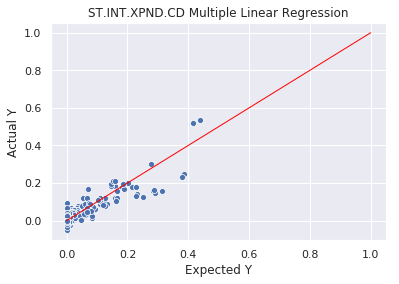

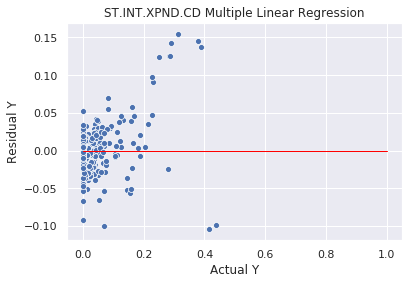

In [14]:
res = lin_model(imputations[0],'ST.INT.XPND.CD')

In [15]:
res_df = pd.DataFrame([res.coef_,df.columns.values]).transpose()
res_df.sort_values(0).set_index(1).head(10).join(data_dictionary.set_index("Code"))

0  \
EN.CO2.TRAN.ZS          -0.209069   
MS.MIL.TOTL.TF.ZS        -17.8819   
Maddison GDPPC           -11.1091   
SE.ENR.PRSC.FM.ZS         -15.982   
ST.INT.ARVL.PER.CAPITA -0.0900676   
ST.INT.RCPT.XP.ZS      -0.0610381   
ST.INT.XPND.CD          -0.223087   
q2                      -0.122706   
q3                       -0.10967   
q5                      -0.120867   

                                                           Indicator Name  
EN.CO2.TRAN.ZS          CO2 emissions from transport (% of total fuel ...  
MS.MIL.TOTL.TF.ZS         Armed forces personnel (% of total labor force)  
Maddison GDPPC          Real GDP per capita in 2011US$, 2011 benchmark...  
SE.ENR.PRSC.FM.ZS       School enrollment, primary and secondary (gros...  
ST.INT.ARVL.PER.CAPITA                      Inbound tourists per resident  
ST.INT.RCPT.XP.ZS       International tourism, receipts (% of total ex...  
ST.INT.XPND.CD          International tourism, expenditures (current US$)  
q2                                      Quintile group shares of resource  
q3                                      Quintile group shares of resource  
q5                                      Quintile group shares of resource

In [16]:
res_df.sort_values(0, ascending=False).set_index(1).head(10).join(data_dictionary.set_index("Code"))

0  \
FB.CBK.DPTR.P3       0.088964   
IT.NET.BBND.P2      0.0323747   
SE.PRM.ENRL.TC.ZS   0.0188795   
SL.AGR.EMPL.ZS      0.0381011   
SL.EMP.MPYR.ZS        1.39863   
SL.IND.EMPL.ZS       0.503005   
SL.TLF.CACT.FM.ZS   0.0317198   
Tourist Avg Net      0.235081   
gdp_ppp_pc_usd2011   0.200838   
q4                   0.115599   

                                                       Indicator Name  
FB.CBK.DPTR.P3      Depositors with commercial banks (per 1,000 ad...  
IT.NET.BBND.P2         Fixed broadband subscriptions (per 100 people)  
SE.PRM.ENRL.TC.ZS                        Pupil-teacher ratio, primary  
SL.AGR.EMPL.ZS      Employment in agriculture (% of total employme...  
SL.EMP.MPYR.ZS      Employers, total (% of total employment) (mode...  
SL.IND.EMPL.ZS      Employment in industry (% of total employment)...  
SL.TLF.CACT.FM.ZS   Ratio of female to male labor force participat...  
Tourist Avg Net                    The average net income per tourist  
gdp_ppp_pc_usd2011  Gross Domestic Product (GDP) is converted to U...  
q4                                  Quintile group shares of resource

### Tourism Receipts

R2 TEST: 0.6719271910514317
MSE TEST: 0.0005680193788115999


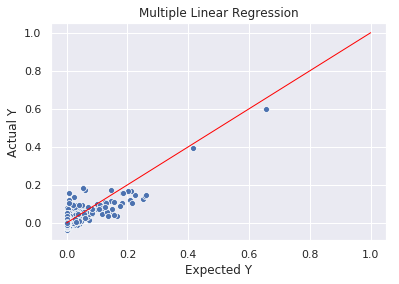

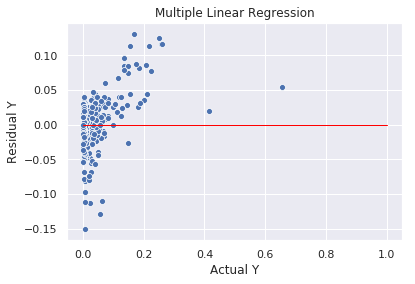

In [17]:
res1 = lin_model_np(pca_x_arrays[4],median_imputed['ST.INT.RCPT.CD'])

In [18]:
res1_df = pd.DataFrame([res1.coef_,df.columns.values]).transpose()
res1_df.sort_values(0).set_index(1).head(10).join(data_dictionary.set_index("Code"))

0  \
EN.CO2.TRAN.ZS         -0.0400534   
FB.CBK.BRWR.P3          -0.115068   
IT.NET.USER.ZS          -0.060925   
Population Estimate    -0.0515161   
SP.DYN.LE00.IN         -0.0418601   
ST.INT.ARVL.PER.CAPITA  -0.060908   
d2                     -0.0563773   
d8                      -0.117151   
mean                   -0.0834953   
q1                     -0.0915482   

                                                           Indicator Name  
EN.CO2.TRAN.ZS          CO2 emissions from transport (% of total fuel ...  
FB.CBK.BRWR.P3          Borrowers from commercial banks (per 1,000 adu...  
IT.NET.USER.ZS           Individuals using the Internet (% of population)  
Population Estimate         The UNPD estimated population for the country  
SP.DYN.LE00.IN                    Life expectancy at birth, total (years)  
ST.INT.ARVL.PER.CAPITA                      Inbound tourists per resident  
d2                                        Decile group shares of resource  
d8                                        Decile group shares of resource  
mean                    Survey mean given with the same underlying def...  
q1                                      Quintile group shares of resource

In [19]:
res1_df.sort_values(0, ascending=False).set_index(1).head(10).join(data_dictionary.set_index("Code"))

0                                     Indicator Name
IT.CEL.SETS.P2   0.200432     Mobile cellular subscriptions (per 100 people)
SH.H2O.SMDW.ZS  0.0950571  People using safely managed drinking water ser...
SH.PRV.SMOK     0.0756518               Smoking prevalence, total (ages 15+)
SH.STA.SUIC.P5   0.124765    Suicide mortality rate (per 100,000 population)
d1                0.14469                    Decile group shares of resource
d3               0.269414                    Decile group shares of resource
d6               0.134255                    Decile group shares of resource
d7               0.188282                    Decile group shares of resource
q3               0.077241                  Quintile group shares of resource
q5               0.125056                  Quintile group shares of resource

### Tourism Arrivals

R2 TEST: 0.5616274700469859
MSE TEST: 0.0058517419709278725


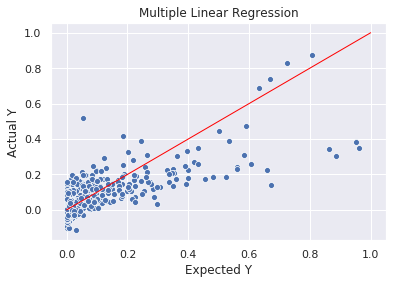

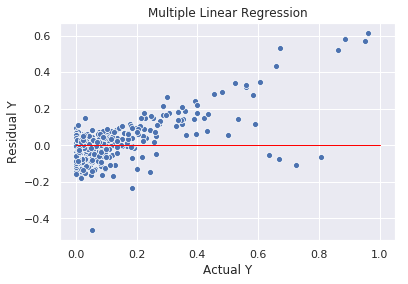

In [20]:
res1 = lin_model_np(pca_x_arrays[2],median_imputed['ST.INT.ARVL'])

In [21]:
res1_df = pd.DataFrame([res1.coef_,df.columns.values]).transpose()
res1_df.sort_values(0).set_index(1).head(10).join(data_dictionary.set_index("Code"))

0  \
EN.ATM.CO2E.PC          -0.247954   
SH.ANM.CHLD.ZS          -0.232302   
SH.H2O.BASW.ZS          -0.189057   
SI.POV.GINI            -0.0862732   
SI.POV.GINI            -0.0862732   
SP.DYN.LE00.IN          -0.162533   
ST.INT.ARVL.PER.CAPITA  -0.185363   
d3                     -0.0980785   
gdp_ppp_pc_usd2011     -0.0829183   
gini_reported           -0.130449   
q1                      -0.162622   

                                                           Indicator Name  
EN.ATM.CO2E.PC                     CO2 emissions (metric tons per capita)  
SH.ANM.CHLD.ZS          Prevalence of anemia among children (% of chil...  
SH.H2O.BASW.ZS          People using at least basic drinking water ser...  
SI.POV.GINI                              GINI index (World Bank estimate)  
SI.POV.GINI                              GINI index (World Bank estimate)  
SP.DYN.LE00.IN                    Life expectancy at birth, total (years)  
ST.INT.ARVL.PER.CAPITA                      Inbound tourists per resident  
d3                                        Decile group shares of resource  
gdp_ppp_pc_usd2011      Gross Domestic Product (GDP) is converted to U...  
gini_reported           Gini coefficient as reported by the source (in...  
q1                                      Quintile group shares of resource

In [22]:
res1_df.sort_values(0, ascending=False).set_index(1).head(10).join(data_dictionary.set_index("Code"))

0                                     Indicator Name
EN.CO2.TRAN.ZS   0.128213  CO2 emissions from transport (% of total fuel ...
FB.CBK.BRCH.P5   0.157991      Commercial bank branches (per 100,000 adults)
FB.CBK.DPTR.P3   0.313927  Depositors with commercial banks (per 1,000 ad...
SH.STA.SUIC.P5  0.0974083    Suicide mortality rate (per 100,000 population)
SI.DST.FRST.10   0.484386                    Income share held by lowest 10%
d1               0.142341                    Decile group shares of resource
d4               0.191241                    Decile group shares of resource
q3              0.0993339                  Quintile group shares of resource
q4               0.278282                  Quintile group shares of resource
q5               0.245921                  Quintile group shares of resource

### Tourism Departures

R2 TEST: 0.34113850209532026
MSE TEST: 0.0036845644746366832


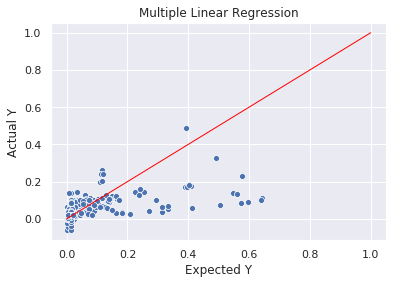

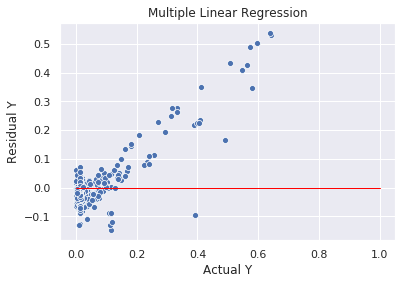

In [23]:
res1 = lin_model_np(pca_x_arrays[0],median_imputed['ST.INT.DPRT'])

In [24]:
res1_df = pd.DataFrame([res1.coef_,df.columns.values]).transpose()
res1_df.sort_values(0).set_index(1).head(10).join(data_dictionary.set_index("Code"))

0  \
EN.ATM.CO2E.PC         -0.0746547   
FB.ATM.TOTL.P5         -0.0782666   
FB.CBK.DPTR.P3         -0.0732182   
SH.STA.SUIC.P5          -0.119751   
SI.DST.10TH.10          -0.159613   
ST.INT.DPRT.PER.CAPITA -0.0738643   
d2                      -0.126577   
d7                      -0.104907   
exchangerate            -0.150738   
median                  -0.116708   

                                                           Indicator Name  
EN.ATM.CO2E.PC                     CO2 emissions (metric tons per capita)  
FB.ATM.TOTL.P5          Automated teller machines (ATMs) (per 100,000 ...  
FB.CBK.DPTR.P3          Depositors with commercial banks (per 1,000 ad...  
SH.STA.SUIC.P5            Suicide mortality rate (per 100,000 population)  
SI.DST.10TH.10                           Income share held by highest 10%  
ST.INT.DPRT.PER.CAPITA                     Outbound tourists per resident  
d2                                        Decile group shares of resource  
d7                                        Decile group shares of resource  
exchangerate            Conversion rate from local currency units (LCU...  
median                  Survey median given with the same underlying d...

In [25]:
res1_df.sort_values(0, ascending=False).set_index(1).head(10).join(data_dictionary.set_index("Code"))

0                                     Indicator Name
EN.CO2.TRAN.ZS   0.388646  CO2 emissions from transport (% of total fuel ...
FB.CBK.BRCH.P5  0.0870063      Commercial bank branches (per 100,000 adults)
FB.CBK.BRWR.P3   0.160714  Borrowers from commercial banks (per 1,000 adu...
SH.H2O.BASW.ZS   0.163075  People using at least basic drinking water ser...
SH.H2O.SMDW.ZS   0.132832  People using safely managed drinking water ser...
SP.DYN.LE00.IN   0.176857            Life expectancy at birth, total (years)
d3              0.0994269                    Decile group shares of resource
gini_reported   0.0830818  Gini coefficient as reported by the source (in...
mean             0.129692  Survey mean given with the same underlying def...
q2               0.122036                  Quintile group shares of resource

## LASSO

In [26]:
from sklearn import linear_model

In [27]:
lin_df = imputations[4]

In [28]:
x_lin = lin_df.drop(tourism_columns, axis="columns").normalize()

In [29]:
reg = linear_model.LassoCV(cv=10)

In [30]:
reg.fit(x_lin,lin_df['ST.INT.RCPT.CD'])

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [31]:
reg.score(x_lin,lin_df['ST.INT.RCPT.CD'])

0.8072314533085984

In [32]:
mean_squared_error(reg.predict(x_lin),lin_df['ST.INT.RCPT.CD'])

0.0006223272057793147

In [33]:
lin_df['LASSO'] = reg.predict(x_lin)

In [34]:
p = figure(title = "LASSO w/ CV Predicted v Actual")
scatter_with_hover(lin_df.reset_index(), 'ST.INT.RCPT.CD','LASSO',cols=['{Country Code}','Year'], fig=p)
p.xaxis.axis_label = 'International tourism receipts Actual'
p.yaxis.axis_label = 'International tourism receipts Predicted'
p.line([0,1], [0,1], line_dash=(4, 4), line_color="orange", line_width=2)
show(p)

## Regression With Tensorflow

In [36]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Y]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Y^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()
  plt.show()

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('')
    print('.', end='')

In [37]:
def train_test(df):
    msk = np.random.rand(len(df)) < 0.8
    train = df[msk]
    test = df[~msk]
    return train, test

In [38]:
def build_model():
  model = keras.Sequential([
    layers.Dense(256, activation=tf.nn.relu, input_shape=[len(x)]),
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dense(256, activation=tf.nn.relu),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.sigmoid),
    layers.Dense(32, activation=tf.sigmoid),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.

....................

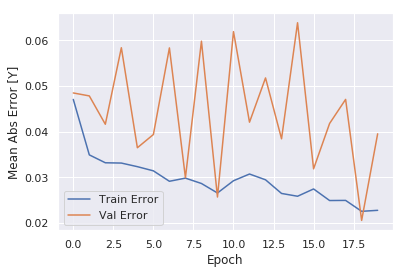

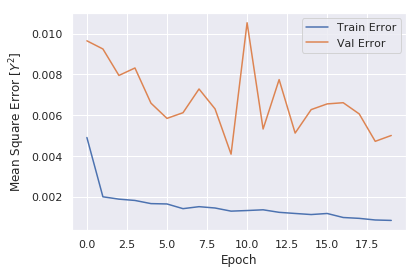

In [39]:
model = build_model()

train, test = train_test(median_imputed)
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train[x], train['ST.INT.RCPT.CD'], epochs=1000,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [40]:
loss, mae, mse = model.evaluate(test[x], test['ST.INT.RCPT.CD'], verbose=0)
print("Testing set Mean Abs Error: {:5.3f}".format(mae))

Testing set Mean Abs Error: 0.033


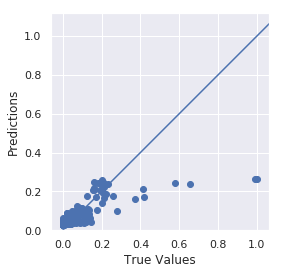

In [41]:
test_predictions = model.predict(test[x]).flatten()
plt.scatter(test['ST.INT.RCPT.CD'], test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-100, 100], [-100, 100])

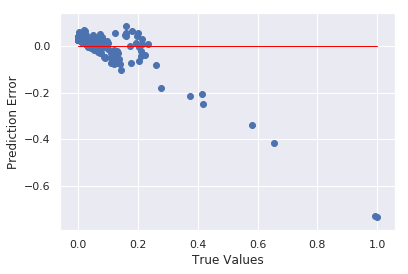

In [42]:
error = test_predictions - test['ST.INT.RCPT.CD']
plt.scatter(test['ST.INT.RCPT.CD'], error)
plt.xlabel('True Values')
plt.ylabel('Prediction Error')
plt.plot([1, 0], [0, 0], linewidth=1,color="red");


.........................
...............

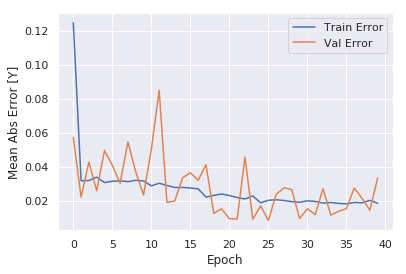

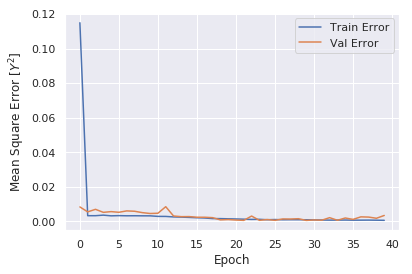

In [43]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train[x], train['ST.INT.XPND.CD'], epochs=1000,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [44]:
loss, mae, mse = model.evaluate(test[x], test['ST.INT.XPND.CD'], verbose=0)
print("Testing set Mean Abs Error: {:5.3f}".format(mae))

Testing set Mean Abs Error: 0.028


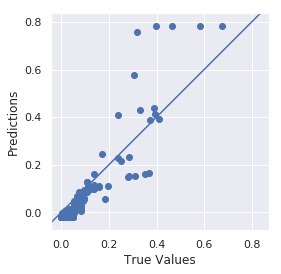

In [45]:
test_predictions = model.predict(test[x]).flatten()
plt.scatter(test['ST.INT.XPND.CD'], test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

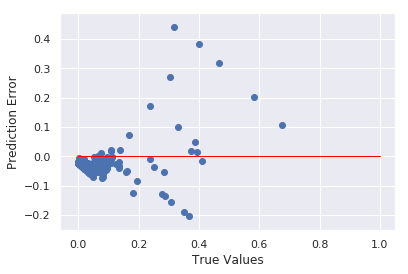

In [46]:
error = test_predictions - test['ST.INT.XPND.CD']
plt.scatter(test['ST.INT.XPND.CD'], error)
plt.xlabel('True Values')
plt.ylabel('Prediction Error')
plt.plot([1, 0], [0, 0], linewidth=1,color="red");